In [1]:
import torch
from IPython import display
from d2l import torch as d2l

#设置数据迭代器的批量⼤⼩为256,并获得训练集和测试集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 初始化模型参数
和之前线性回归的例⼦⼀样，这⾥的每个样本都将⽤固定⻓度的向量表⽰。原始数据集中的每个样本都是28×28的图像。本节将展平每个图像，把它们看作⻓度为784的向量。  
在softmax回归中，输出与类别⼀样多。因为我们的数据集有10个类别，所以⽹络输出维度为10。因此，权重将构成⼀个784 × 10的矩阵，偏置将构成⼀个1 × 10的⾏向量。与线性回归⼀样，我们将使
正态分布初始化我们的权重W，偏置初始化为0。


In [2]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

# 定义softmax操作
如果X是⼀个形状为(2, 3)的张量，我们对列进⾏求和，则结果将是⼀个具有形状(3,)的向量。当调⽤sum运算符时，我们可以指定保持在原始张量的轴数，⽽不折叠求和的维度。这将产⽣⼀个具有形状(1, 3)的⼆维张量。

In [3]:
#简单来说，一个是对列求和，一个是对行求和
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现softmax由三个步骤组成：
* 对每个项求幂（使⽤exp）；
* 对每⼀⾏求和（⼩批量中每个样本是⼀⾏），得到每个样本的规范化常数；
* 将每⼀⾏除以其规范化常数，确保结果的和为1。  
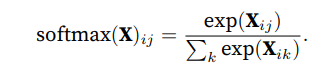


In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这⾥应⽤了⼴播机制

In [6]:
#测试softmax函数
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0313, 0.0760, 0.5711, 0.2075, 0.1141],
         [0.0539, 0.0698, 0.1840, 0.1117, 0.5806]]),
 tensor([1.0000, 1.0000]))

# 定义模型
定义softmax操作后，我们可以实现softmax回归模型。下⾯的代码定义了输⼊如何通过⽹络映射到输出。注意，将数据传递到模型之前，我们使⽤reshape函数将每张原始图像展平为向量。


In [7]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


# 定义损失函数
引⼊交叉熵损失函数。这可能是深度学习中最常⻅的损失函数，因为⽬前分类问题的数量远远超过回归问题的数量。  
交叉熵采⽤真实标签的预测概率的负对数似然。这⾥我们不使⽤Python的for循环迭代预测（这往往是低效的），⽽是通过⼀个运算符选择所有元素。下⾯，我们创建⼀个数据样本y_hat，其中包含2个样本在3个类别的预测概率，以及它们对应的标签y。有了y，我们知道在第⼀个样本中，第⼀类是正确的预测；⽽在第⼆个样本中，第三类是正确的预测。然后使⽤y作为y_hat中概率的索引，我们选择第⼀个样本中第⼀个类的概率和第⼆个样本中第三个类的概率。


In [8]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [9]:
# 实现交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

# 分类精度
给定预测概率分布y_hat，当我们必须输出硬预测（hard prediction）时，我们通常选择预测概率最⾼的类。许多应⽤都要求我们做出选择。如Gmail必须将电⼦邮件分类为“Primary（主要邮件）”、“Social（社交邮件）”“Updates（更新邮件）”或“Forums（论坛邮件）”。Gmail做分类时可能在内部估计概率，但最终它必须在类中选择⼀个。  

当预测与标签分类y⼀致时，即是正确的。分类精度即正确预测数量与总预测数量之⽐。虽然直接优化精度可能很困难（因为精度的计算不可导），但精度通常是我们最关⼼的性能衡量标准，我们在训练分类器时⼏乎总会关注它。  

为了计算精度，我们执⾏以下操作。⾸先，如果y_hat是矩阵，那么假定第⼆个维度存储每个类的预测分数。我们使⽤argmax获得每⾏中最⼤元素的索引来获得预测类别。然后我们将预测类别与真实y元素进⾏⽐较。由于等式运算符“==”对数据类型很敏感，因此我们将y_hat的数据类型转换为与y的数据类型⼀致。结果是⼀个包含0（错）和1（对）的张量。最后，我们求和会得到正确预测的数量。


In [10]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [11]:
# 继续使⽤之前定义的变量y_hat和y分别作为预测的概率分布和标签
accuracy(y_hat, y) / len(y)

0.5

同样，对于任意数据迭代器data_iter可访问的数据集，我们可以评估在任意模型net的精度;  
这⾥定义⼀个实⽤程序类Accumulator，⽤于对多个变量进⾏累加。在上⾯的evaluate_accuracy函数中，我们在Accumulator实例中创建了2个变量，分别⽤于存储正确预测的数量和预测的总数量。当我们遍历数据集时，两者都将随着时间的推移⽽累加。

In [12]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [16]:
#由于我们使⽤随机权重初始化net模型，因此该模型的精度应接近于随机猜测。
#例如在有10个类别情况下的精度为0.1。
evaluate_accuracy(net, test_iter)

0.0939

# 训练
定义⼀个函数来训练⼀个迭代周期。请注意，updater是更新模型参数的常⽤函数，它接受批量⼤⼩作为参数。它可以是d2l.sgd函数，也可以是框架的内置优化函数。

In [17]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """训练模型⼀个迭代周期（定义⻅第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使⽤PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使⽤定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

定义⼀个在动画中绘制数据的实⽤程序类Animator，它能够简化本书其余部分的代码。



In [23]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使⽤lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


实现⼀个训练函数，它会在train_iter访问到的训练数据集上训练⼀个模型net。该训练函数将会运⾏多个迭代周期（由num_epochs指定）。在每个迭代周期结束时，利⽤test_iter访问到的测试数据集对模型进⾏评估。我们将利⽤Animator类来可视化训练进度。


In [19]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型（定义⻅第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

定义的⼩批量随机梯度下降来优化模型的损失函数，设置学习率为0.1。

In [20]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

训练模型10个迭代周期。请注意，迭代周期（num_epochs）和学习率（lr）都是可调节的超参数。通过更改它们的值，我们可以提⾼模型的分类精度。

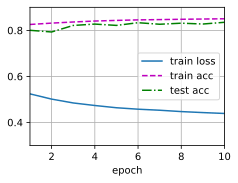

In [24]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

# 预测
现在训练已经完成，我们的模型已经准备好对图像进⾏分类预测。给定⼀系列图像，我们将⽐较它们的实际标签（⽂本输出的第⼀⾏）和模型预测（⽂本输出的第⼆⾏）。

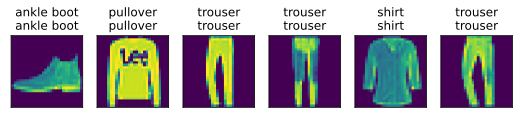

In [25]:
def predict_ch3(net, test_iter, n=6): #@save
    """预测标签（定义⻅第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# 小结
* 借助softmax回归，我们可以训练多分类的模型。
* 训练softmax回归循环模型与训练线性回归模型⾮常相似：先读取数据，再定义模型和损失函数，然后使⽤优化算法训练模型。⼤多数常⻅的深度学习模型都有类似的训练过程。